This notebook will serve as a walkthrough of the main experiments in the paper "A Implies B: Circuit Analysis in LLMs for Propositional Logical Reasoning". In particular, this notebook will cover the main body of the workflow: from basic setup of the environment, to model loading, to data generation, to circuit search using activation patching (based on tools from the wonderful TransformerLens library), to attention head interpretations, and finally, to circuit verification. Note that we delay the finer-grained "causal surgeries" to the second part of this series of notebooks, to avoid making this one overly long.

This notebook was tested on a cloud computing machine with an H200; we recommend running it on a (Multi-GPU) machine with abundant VRAM, since we will be running intervention experiments with models which are relatively large in size (~10B), and need to cache some of their activations in addition to their logits.

An additional note: the research work in the paper was conducted inside Google; this series of notebook is our best attempt at replicating the main experiments in the paper using external tools, with limited computing resources, so there will be certain less important details which will not be covered here.

# Setup: imports, and model loading

## Basic imports

In [ ]:
import numpy as np
import sys
import copy
import random
import os

In [ ]:
from pathlib import Path
import re


from functools import partial
from itertools import product
from pathlib import Path
from typing import Callable, Literal
from IPython.display import HTML, display, IFrame
from tqdm.notebook import tqdm

#%pip install transformer_lens==2.14.0 einops jaxtyping git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

## Environment setup and additional imports

In [ ]:
# Uncomment below to install necessary tools if you have not
# done so with the requirements for TransformerLens.
# Also, ensure that the torch install is up to date!

'''
%pip install plotly
%pip install -U matplotlib
%pip install einops
%pip install jaxtyping

%pip install -U "typing_extensions>=4.12.0"
%pip install wandb
%pip install typeguard
%pip install transformers
%pip install datasets
%pip install rich
%pip install better-abc

# Bring the torch environment up to date if needed.
# Wipe the mismatched versions first.
%pip uninstall -y torch torchvision torchaudio

# Torch 2.4.x + matching vision/audio
# (+cu121 works as of the time of this code's release)
%pip install --no-cache-dir \
    torch==2.4.1+cu121 \
    torchvision==0.19.1+cu121 \
    torchaudio==2.4.1+cu121 \
    --index-url https://download.pytorch.org/whl/cu121
'''

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
Found existing installation: torchvision 0.19.1+cu121
Uninstalling torchvision-0.19.1+cu121:
  Successfully uninstalled torchvision-0.19.1+cu121
Found

In [ ]:
# Additional imports, after handling the installs
from torch import Tensor
from jaxtyping import Bool, Float, Int
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Any, Union
#from rich import print as rprint
#from rich.table import Column, Tzable
import plotly.express as px
import einops
import torch as t
import torch
from transformer_lens import ActivationCache, HookedTransformer, utils
from transformer_lens.components import MLP, Embed, LayerNorm, Unembed
from transformer_lens.hook_points import HookPoint

In [ ]:
# Disable gradient calculations, saves VRAM
t.set_grad_enabled(False)
device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

## Model loading

In [ ]:
global_random_seed = 0
# we switch querying for LO to lin, or the other way around
experiment_id = "Gemma2_9B_QUERYSwitch_ActivationPatching_randSeed="+str(global_random_seed)

# Set global random seeds
torch.manual_seed(global_random_seed)
np.random.seed(global_random_seed)
random.seed(global_random_seed)

In [ ]:
# If you do not have Gemma-2-9B locally, you can uncomment the code
# below to log into Huggingface, since Gemma-2-9B requires approval
# on your Huggingface account to download
#from huggingface_hub import login
#login()

In [ ]:
# Load the LLM (and download the weights if the first time)
model = HookedTransformer.from_pretrained(
    "gemma-2-9b",
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=True,
    #n_devices=1,  # if loading onto >1 GPUs, specify the number of GPUs here
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b into HookedTransformer


# Data generation

## Text data generation

To start off our analysis, we will work with the most basic setting in the paper: QUERY-based patching of the first answer token, namely the key place in the proof where the model needs to decide which fact to invoke in writing the minimal proof. The logic problem would consist of one disjunction chain, and one linear chain.

We rely on the helper function ```generate_cot_question_query_based``` to generate the problem and answer (proof) pairs. In particular, this function will return two problem-answer pairs where everything in the pair is the same, except the queried chain differs. This creates a minimally different "corrupt" or "altered" problem pair to examine the information flow inside the LLM for deciding how to write the proof for a distinct chain.

We will work with problem-answer pairs with more nuanced contrastive differences, such as rule location swaps and fact-value changes later (in other notebook files). However, this QUERY-based patching exercise will help us see the big picture of the circuit used for deciding how to invoke the right fact. Moreover, we will see that those more nuanced experiments primarily serve as finer "causal surgeries" which surface _subcircuits_ in the full circuit discovered in this exercise, so it is sensible to work with the current data setting first.

In [ ]:
from helpers.disj_problem_generation import generate_cot_question_query_based

In [ ]:
clean_prompts = []
corrupt_prompts = []
gt_answers = []
clean_prob_info = []
corrupt_prob_info = []
# Set the number of in-context examples provided to the LLM for answering the new problem
NUM_EXAMPLES = 4

NUM_BASE_TEST_EXAMPLES = 300
for i in range(NUM_BASE_TEST_EXAMPLES):
    question_string_LO, gt_string_LO, question_string_lin, gt_string_lin, problem_info_dict_LO, problem_info_dict_lin = generate_cot_question_query_based(num_cot_samples = NUM_EXAMPLES)

    clean_prompts.append(question_string_lin)
    clean_prompts.append(question_string_LO)
    clean_prob_info.append(problem_info_dict_lin)
    clean_prob_info.append(problem_info_dict_LO)

    corrupt_prompts.append(question_string_LO)
    corrupt_prompts.append(question_string_lin)
    corrupt_prob_info.append(problem_info_dict_lin)
    corrupt_prob_info.append(problem_info_dict_LO)


    gt_answers.append(gt_string_lin)
    gt_answers.append(gt_string_LO)

answers = []
for i in range(NUM_BASE_TEST_EXAMPLES):
  answers.append((" "+gt_answers[2*i][0], " "+gt_answers[2*i+1][0]))
  answers.append((" "+gt_answers[2*i+1][0], " "+gt_answers[2*i][0]))

In [ ]:
# print a few problems and proofs for sanity check
for i in range(2):
    print("Clean problem "+str(i)+".")
    print(clean_prompts[i])
    print("Clean Proof "+str(i)+".")
    print(gt_answers[i])
    print("'Corrupt' problem "+str(i)+".")
    print(corrupt_prompts[i])
    print("Answer pairs "+str(i)+", in format (Correct first answer token, Incorrect first answer token)")
    print(answers[i])
    print()


Clean problem 0.
Rules: C or U implies Z. V implies R. Facts: C is true. V is true. U is false. Question: state the truth value of R. Answer: V is true. V implies R; R is true.
Rules: P implies S. R or U implies T. Facts: P is true. U is true. R is false. Question: state the truth value of S. Answer: P is true. P implies S; S is true.
Rules: F or H implies Q. C implies V. Facts: C is true. H is true. F is false. Question: state the truth value of Q. Answer: H is true. F or H implies Q; Q is true.
Rules: L implies M. B or P implies G. Facts: B is true. L is false. P is false. Question: state the truth value of G. Answer: B is true. B or P implies G; G is true.
Rules: T or N implies P. H implies W. Facts: T is true. H is true. N is false. Question: state the truth value of W. Answer:
Clean Proof 0.
H is true. H implies W; W is true.
'Corrupt' problem 0.
Rules: C or U implies Z. V implies R. Facts: C is true. V is true. U is false. Question: state the truth value of R. Answer: V is true. 

## Convert text to tokens

In [ ]:
# Tokenize the prompts
clean_tokens = model.to_tokens(clean_prompts, prepend_bos=True, padding_side="left")
clean_tokens = clean_tokens.to(device)
corrupted_tokens = model.to_tokens(corrupt_prompts, prepend_bos=True, padding_side="left")
corrupted_tokens = corrupted_tokens.to(device)

# Obtain the answer-tuple tokens
answer_tokens = t.concat([
    model.to_tokens(item, prepend_bos=False).T for item in answers
])

# Analysis of attention heads

## Activation patching of attention-head outputs

### Patching function definition

In [ ]:
from helpers.patching_helpers_custom import logits_diff
from helpers.patching_helpers_custom import basic_metric
from helpers.patching_helpers_custom import basic_patching

In [ ]:
# Compute clean logit differences for later use
n_batch = 30
batch_size = 8
clean_logit_diff_history = []
model.reset_hooks(including_permanent=True)
for batch_idx in tqdm(range(n_batch)):
    clean_logits = model(clean_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)])
    clean_logit_diffs = logits_diff(clean_logits, answer_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], per_prompt=True)
    clean_logit_diff_history += clean_logit_diffs

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
average_clean_logit_difference = np.mean(clean_logit_diff_history)
print("Average clean logit difference:", average_clean_logit_difference)

Average clean logit difference: 1.8642977


### Run activation patching: search for circuit components

In [ ]:
import pickle
import itertools
clean_logits = None
clean_cache = None
torch.cuda.empty_cache() # PyTorch thing

act_patch_history = []
batch_size = 8

# If you want, save the batch results to prevent significant loss of data.
save_results = True

In [ ]:
for i in range(1): # Run for 1 batch for sanity check. Increase it for more stable results!
    print(f"Batch {i}")
    start_sample_idx = i*batch_size
    end_sample_idx = (i+1)*batch_size
    # We are only patching the attention head output in this part of the analysis, so just cache the "z" activation.
    z_name_filter = lambda name: name.endswith("z")
    clean_logits, clean_cache = model.run_with_cache(clean_tokens[start_sample_idx:end_sample_idx], names_filter=z_name_filter)
    corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens[start_sample_idx:end_sample_idx], names_filter=z_name_filter)

    # Compute the logits on the clean and corrupted samples in this batch
    clean_logit_diff = logits_diff(clean_logits, answer_tokens[start_sample_idx:end_sample_idx])
    clean_logit_diff_per_prompt = logits_diff(clean_logits, answer_tokens[start_sample_idx:end_sample_idx], per_prompt=True)
    print(f"Clean logit diff: {clean_logit_diff:.4f}")
    print(f"Clean logit diff per prompt:", clean_logit_diff_per_prompt)

    corrupted_logit_diff = logits_diff(corrupted_logits, answer_tokens[start_sample_idx:end_sample_idx])
    corrupted_logit_diff_per_prompt = logits_diff(corrupted_logits, answer_tokens[start_sample_idx:end_sample_idx], per_prompt=True)
    print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")
    print(f"Corrupted logit diff per prompt:", corrupted_logit_diff_per_prompt)

    # Specify the answer token pairs (clean and corrupt) of this batch
    answer_tokens_batch = answer_tokens[start_sample_idx:end_sample_idx].cpu()

    # Perform activation patching
    patched_logit_diffs = basic_patching(
        model = model,
        clean_tokens = clean_tokens[start_sample_idx:end_sample_idx],
        corrupted_cache = corrupted_cache,
        clean_logit_diff = clean_logit_diff,
        corrupted_logit_diff = corrupted_logit_diff,
        metric = basic_metric,
        component = ["z"],
        answer_tokens_batch = answer_tokens_batch,
        GQA_constant = 2,
        positions_l = -5,
        positions_u = 0,
        batch_size = batch_size,
    )

    # Remark: We set positions_l = 5 and position_u = 0, basically to patch the last 5 token positions,
    # covering the span of QUERY to the last position. Due to the causal nature of the LLM, this covers all
    # possible positions which could have activations changed due to the QUERY flip.

    act_patch_history.append(patched_logit_diffs)


    if save_results:
        print("Saving data")
        experiment_id = "gemma-2-9b_disj_z_patching_seed="+str(global_random_seed)+"_batch_size="+str(batch_size)+"_batch="+str(i)

        exp_record_batch = {"experiment_id": experiment_id,
                            "clean_prompts": clean_prompts,
                            "corrupt_prompts": corrupt_prompts,
                            "answers": gt_answers,
                            "clean_tokens": clean_tokens,
                            "corrupted_tokens": corrupted_tokens,
                            "answer_tokens": answer_tokens,
                            "random_seed": global_random_seed,
                            "clean_logit_diff_per_prompt": clean_logit_diff_per_prompt,
                            "corrupted_logit_diff_per_prompt": corrupted_logit_diff_per_prompt,
                            "patched_logit_diffs": patched_logit_diffs,
                            "act_patch_history": act_patch_history}

        # Create a save directory
        #save_dir = Path("/workspace/data")
        #save_dir.mkdir(parents=True, exist_ok=True)

        save_dir = "/workspace/results"
        fname = save_dir+"/ExpID="+str(experiment_id)+".pkl"

        with open(fname, "wb") as f:
            pickle.dump(exp_record_batch, f, protocol=pickle.HIGHEST_PROTOCOL)

        print(f"Saved to {fname}")

    # Clean up and release some VRAM for the next batch
    clean_logits = None
    clean_cache = None
    torch.cuda.empty_cache()


### Process and visualize results

In [ ]:
# Aggregate the batches of results
act_patch_avg = np.zeros((model.cfg.n_layers, model.cfg.n_heads))
print(act_patch_history[0].shape)
for batch_i in range(len(act_patch_history)):
    for ll in range(model.cfg.n_layers):
        for hh in range(model.cfg.n_heads):
            act_patch_avg[ll, hh] += torch.mean(act_patch_history[batch_i][0][ll][hh])
act_patch_avg /= len(act_patch_history)

torch.Size([1, 42, 16, 8])


In [ ]:
print(np.max(act_patch_avg))

0.6254809498786926


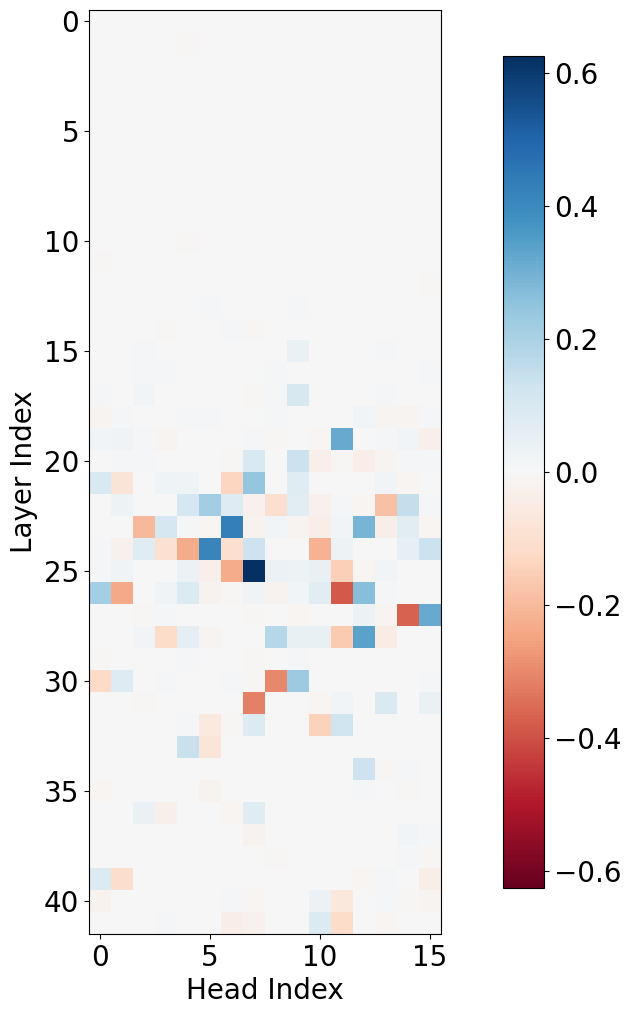

In [ ]:
plt.figure(figsize=(16, 12))
plt.rcParams.update({'font.size': 20})

heatmap = plt.imshow(act_patch_avg, cmap='RdBu', vmin=-np.max(act_patch_avg), vmax=np.max(act_patch_avg))
plt.colorbar(heatmap, shrink=0.9)
ax = plt.gca()
ax.set_xlabel("Head Index")
ax.set_ylabel("Layer Index")
plt.savefig("/workspace/data/fact_rule_question_z_sweep_gemma-2-9B.pdf", format="pdf")

## Interpreting the attention patterns

We found a sparse set of attention heads exhibit strong indirect effects in resolving the first answer token (the key place in deciding which fact to invoke in the proof). In particular, we have the following set of heads with top causal scores: {(19, 11), (20, 7), (21, 7), (22, 5), (23, 6), (23, 12), (24, 5) (24, 15), (25, 7), (26, 0), (26, 12), (28, 12),(30, 9)}. Let us now try to interpret what functions they might have.
To make things somewhat more organized, we analyze the heads in the groups which we found to have similar attention patterns, namely the rule locators, movers, fact processors, and decision heads.

### Attention pattern visualization

In [ ]:
# Visualize attention patterns of selected attention heads, on a selected sample
# clean_tokens[sample_idx].
def visualize_heads(heads_vis, sample_idx=0):
    """
    head_vis is a list of tuples [(L_1, H_1), (L_2, H_2), ..., (L_n, H_n)],
    for specifying the layer and head indices of the attention heads visualized.

    In the generated heatmap plots, horizontal axis indicates the source token positions,
    vertical axis display the destination token positions, all within the span of the
    final problem (excluding in-context examples).
    Every token is converted back to text for meaningful visualization -- no two token
    is merged in this de-tokenizing process.
    """
    for i, head in enumerate(heads_vis):
        plt.figure(i, figsize=(20,10))
        plt.rcParams.update({'font.size': 20})
        layer_idx = head[0]
        head_idx = head[1]
        z_name_filter = lambda name: name.endswith("pattern")
        logits_, cache = model.run_with_cache(clean_tokens[sample_idx:sample_idx+1], names_filter=z_name_filter)
        labels = [tok for i, tok in enumerate(model.to_str_tokens(clean_tokens[sample_idx]))]
        heatmap = plt.imshow(cache["pattern", layer_idx][0, head_idx][-5:,-37:].cpu())
        plt.xticks(ticks=range(37), labels=labels[-37:], rotation=85)
        plt.yticks(ticks=range(5), labels=labels[-5:])
        plt.colorbar(heatmap, shrink=0.3)
        plt.title("Attention pattern of head ("+str(layer_idx)+","+str(head_idx)+"), sample idx "+str(sample_idx))
        plt.show()
    cache = None
    logits_ = None
    torch.cuda.empty_cache()


### Visualizations on single samples

**Rule locators**: (19, 11), (21, 0), (21, 7), (22, 5), (23, 12).

This set of heads "kicks off" the "reasoning" circuit in the Gemma-2-9B model for our problem. At the QUERY token position, their attention patterns are observed to primarily concentrate on the conclusion variable (and nearby tokens) of the queried rule. Let us first visualize their attention patterns on an actual sample, to get a sense of what their functionalities.

Note: in the generated heatmaps, the horizontal axis indicates the source token positions, the vertical axis display the destination token positions, all within the span of the final problem (excluding in-context examples). Moreover, every token is converted back to text for meaningful visualization -- no two token is merged in this de-tokenizing process.

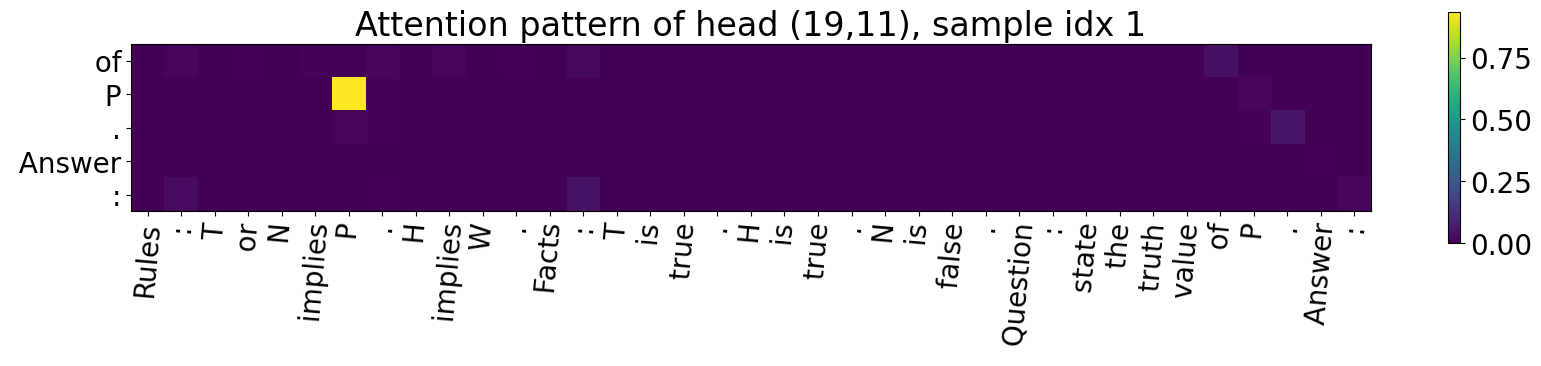

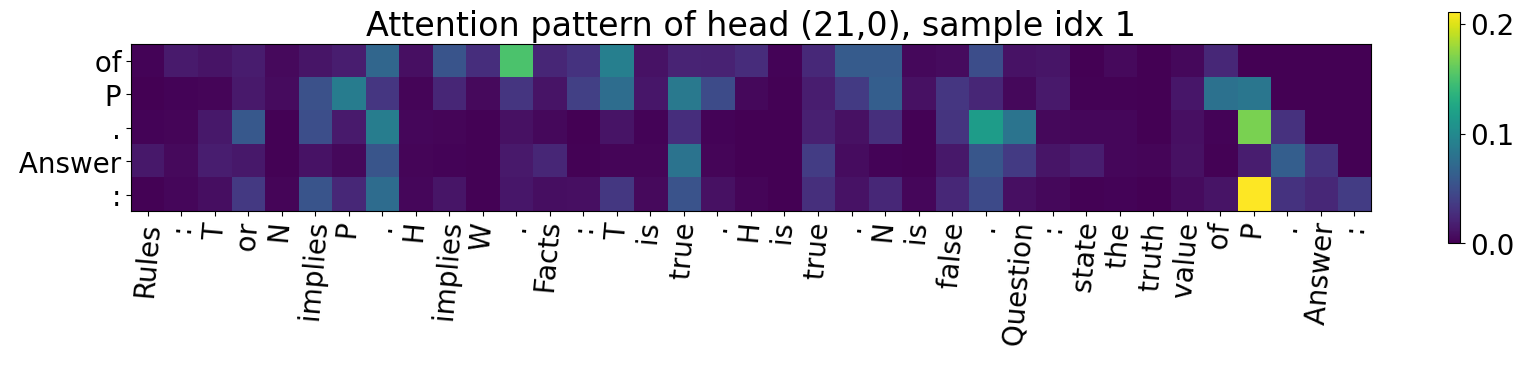

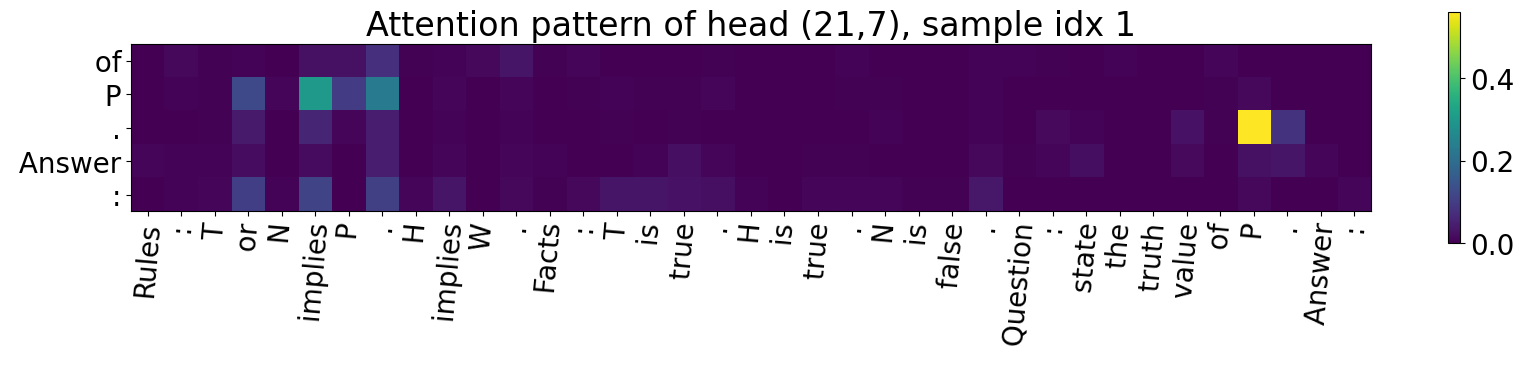

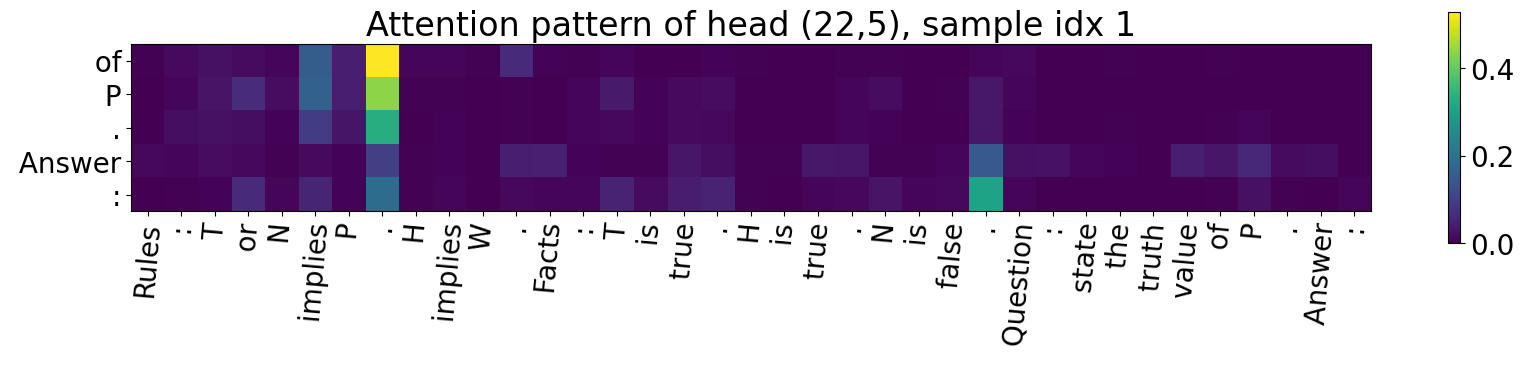

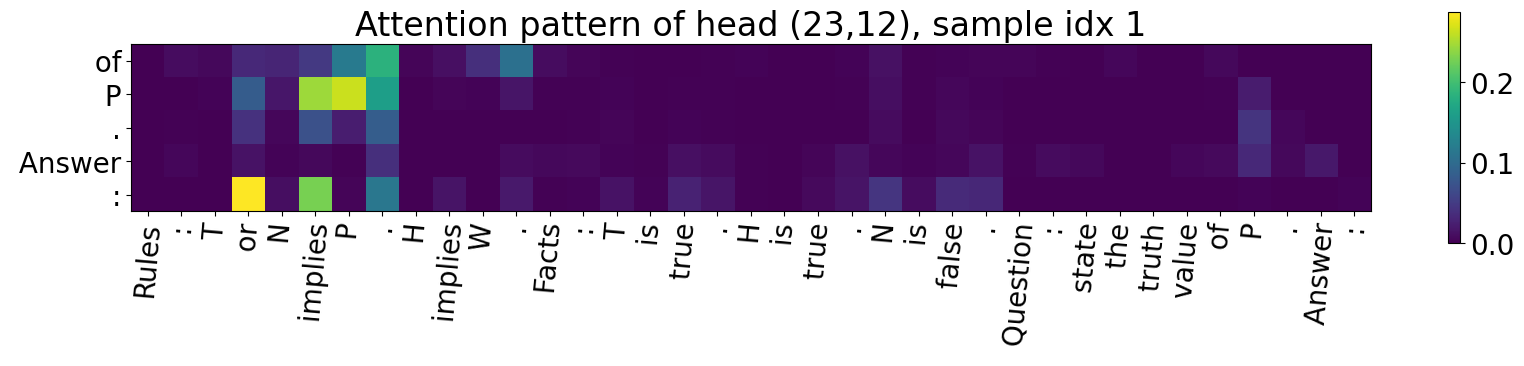

In [ ]:
# Let us first visualize their attention patterns on an actual sample, to
# get a sense of what they are doing.


visualize_heads(heads_vis = [(19,11), (21,0), (21,7), (22,5), (23,12)], sample_idx=1)

**Mover heads**: (20, 7), (23, 6), (24, 15), (27, 15).

These are somewhat more commonly found in other works, where they are observed to perform certain moving functions. In our case, at the final token position ":", they tend to place consistent attention weight on the QUERY position (and more weakly, on the positions following it), with little sensitivity to the QUERY flipping action. Coupled with their nontrivial causal scores, they appear to move the information already obtained at the QUERY position and nearby tokens from the lower layers to the final token position. In fact, this already suggests that it is not their QUERY-sensitive attention action, but rather the value which they pass out which leads to their nontrivial causal scores (we will examine this later).

Observations: Head (20,7) also places some attention in the rule section at the final token position on some samples, and in such instances it does not place as much attention on QUERY and the nearby tokens. It is somewhat "poly-semantic". In comparison, heads (23,6)'s attention pattern is more consistently focused on QUERY and nearby tokens, on most destination token positions after QUERY. Head (24,15), slightly deeper in the model, has more diffuse attention on all token positions from QUERY to the last token position, so it seems to not only move, but also accumulate information obtained so far (from the queried-rule locator heads, which are in shallower layers in the model).

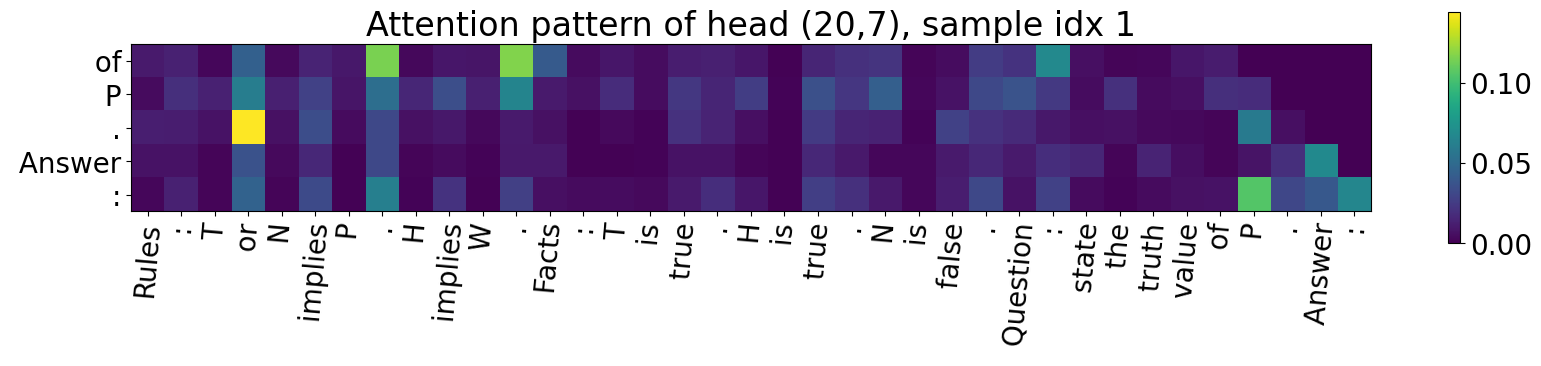

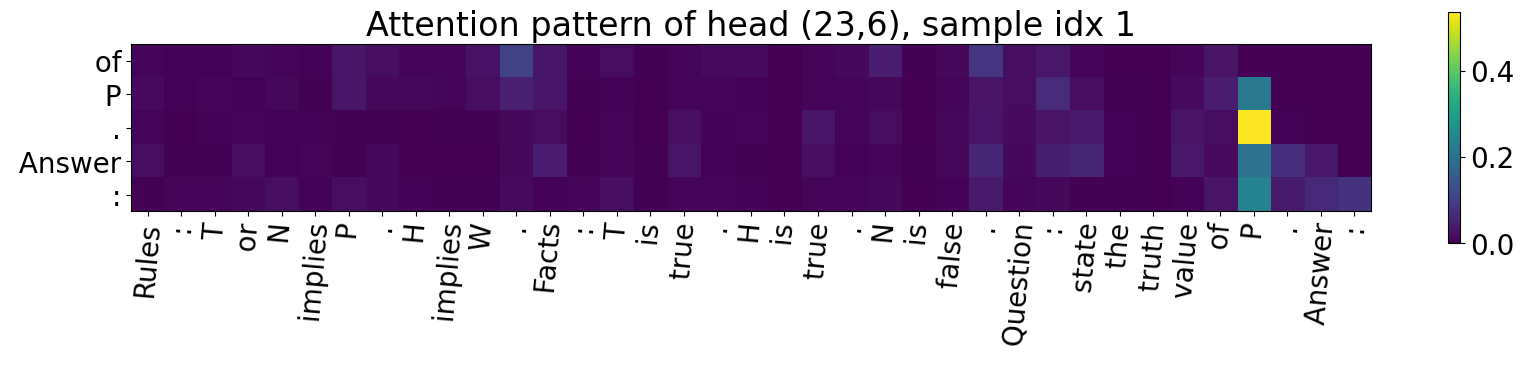

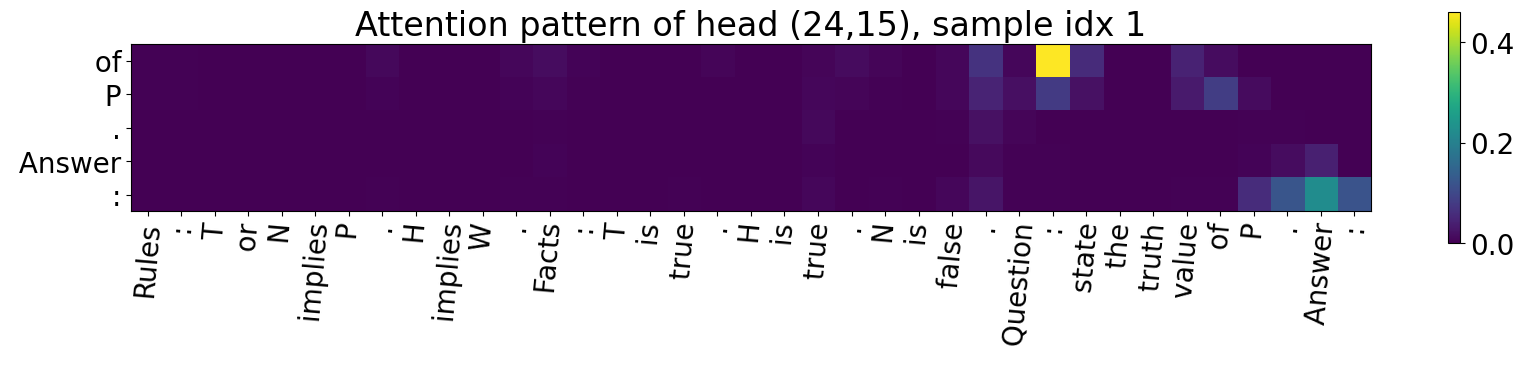

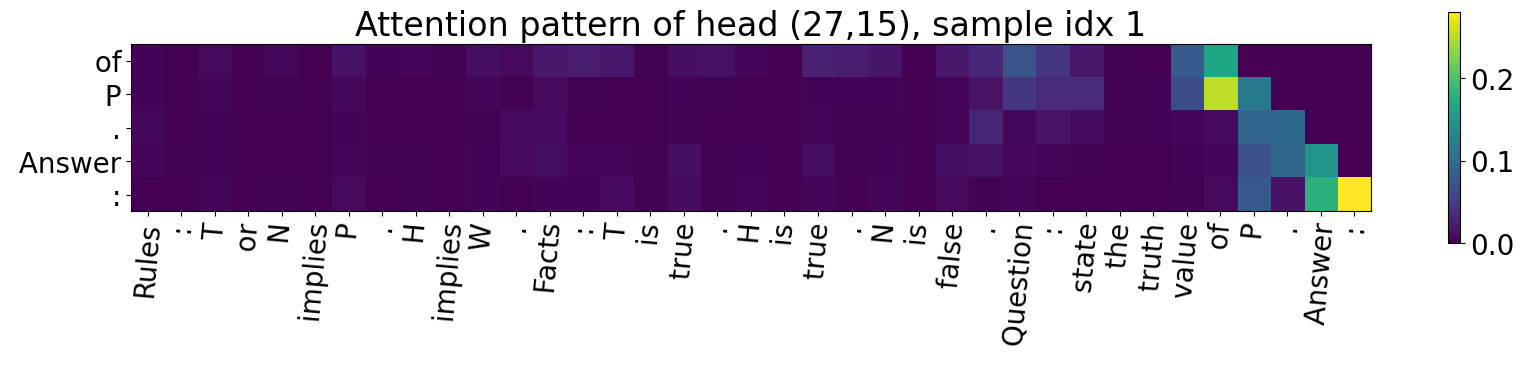

In [ ]:
visualize_heads(heads_vis = [(20, 7), (23, 6), (24, 15)], sample_idx=1)

**Fact processors**: (24, 5), (25, 7), (26, 0), (26, 12).

At the final token position, this set of heads exhibit strong tendency to place heavy attention on the _correct fact-sentence_ to invoke. In other words, the model is getting very close to the right answer token to write down, by the time these heads activate. Notice that they are also deeper down in the LLM on average compared to the rule locators and movers.

An intriguing observation is that, even for a problem which queries the linear chain, these heads still place heavy attention on the correct fact-sentence, even though there is no necessity for these heads to perform anything remotely meaningful for such problems (e.g. they could just perform attention sink and output meaningless signals), since the model can just take the shortcut and write down the correct first answer token by looking at the queried linear rule. Therefore, these attention heads appear to pay attention to factual assignments regardless of whether the actual question really requires them to do their job.

Note 1: It is worth noting is that some of these attention heads also place weak, but nontrivial attention on the queried rule at the QUERY token position, indicating that they are weakly "poly-semantic".

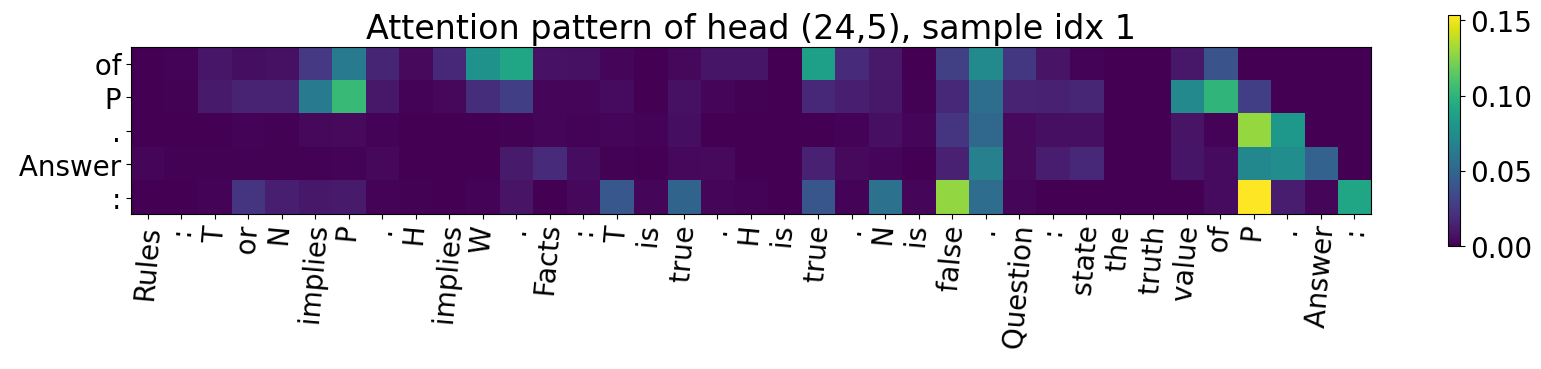

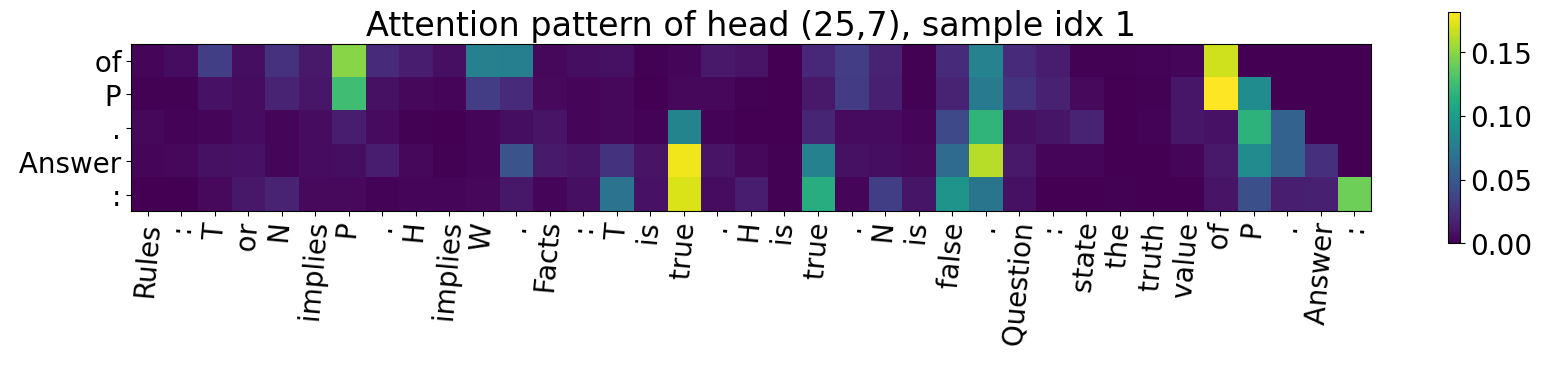

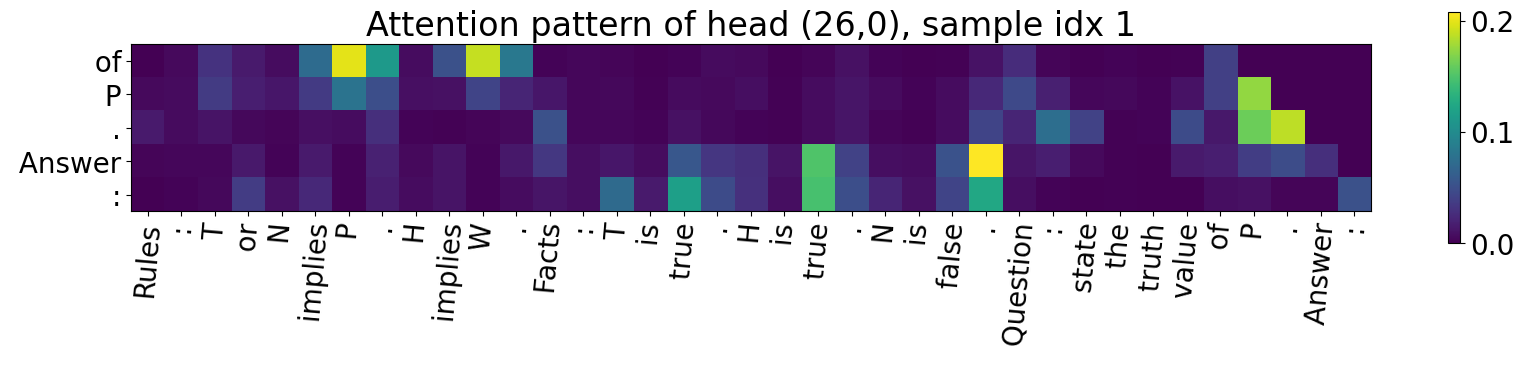

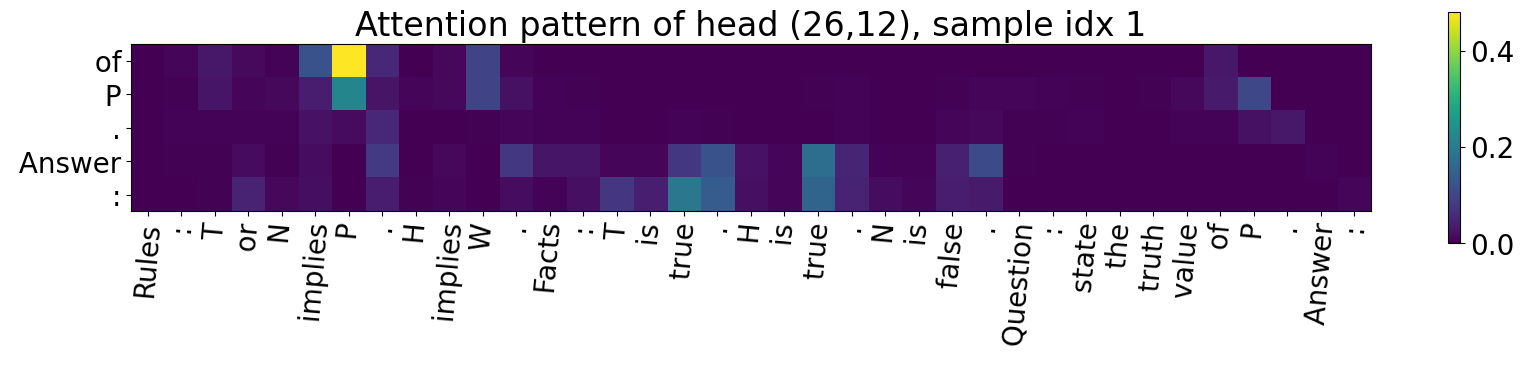

In [ ]:
visualize_heads(heads_vis = [(24, 5), (25, 7), (26, 0), (26, 12)], sample_idx=1)

**Decision heads**: (28, 12), (30, 9)

These decision heads serve as the last step in the "reasoning circuit" of Gemma-2-9B on our problem: at the final token position: they place heavy attention only on the right token to write down, for the first answer token in the proof. This is also one reason we separate them from the fact-processing heads: their attention pattern is much more specialized to focus solely on the right token to write down, instead of spreading over a full sentence. Note that the layers they are in (28 and 30) are also the deepest in the circuit.

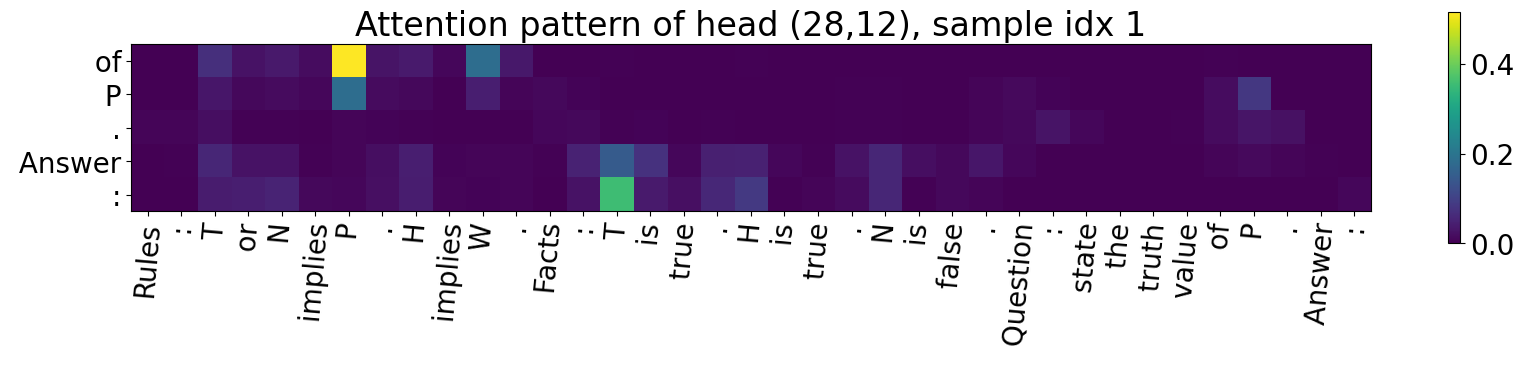

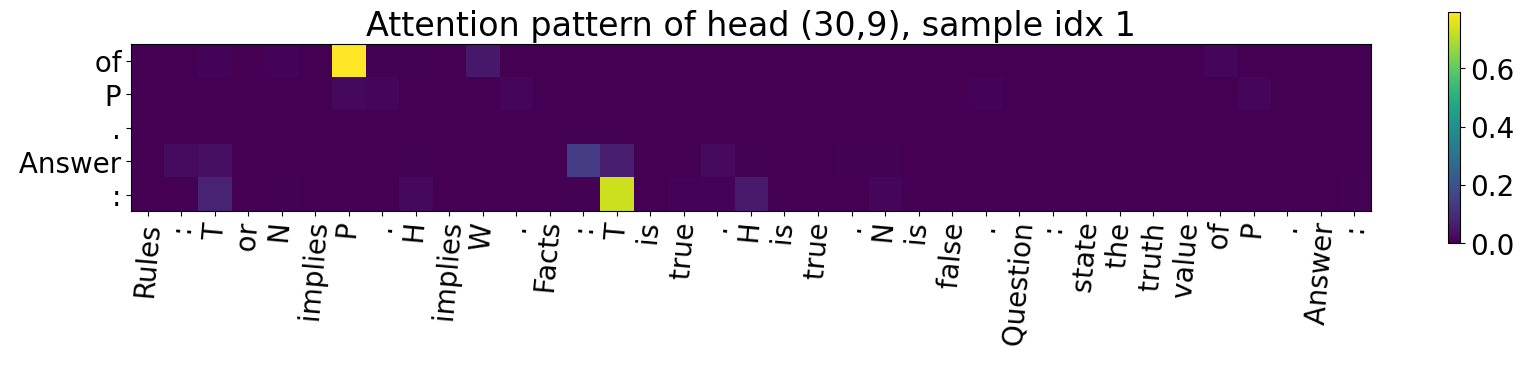

In [ ]:
visualize_heads(heads_vis = [(28, 12), (30, 9)], sample_idx=1)

*Post-processing head*: (27,15), (33,4)

Interestingly, these attention heads deep in the layers show nontrivial indirect effect, but their attention patterns are quite "diagonal" in nature: setting the last token position as the destination, its attention focuses almost solely on the last token position and QUERY. Interestingly, as we will see later in the circuit verification stage, having this kind of attention at the end of the circuit actually helps improve the performance recovery. In other words, even though these heads (especially (33,4)) come after the decision heads, they apparently perform certain post-processing to better separate the correct answer token from the incorrect ones at the logit level.

Note: there are other heads with nontrivial causal scores also exhibiting this behavior deep in the model, but these two, especially (33,4) are representative ones to see here.

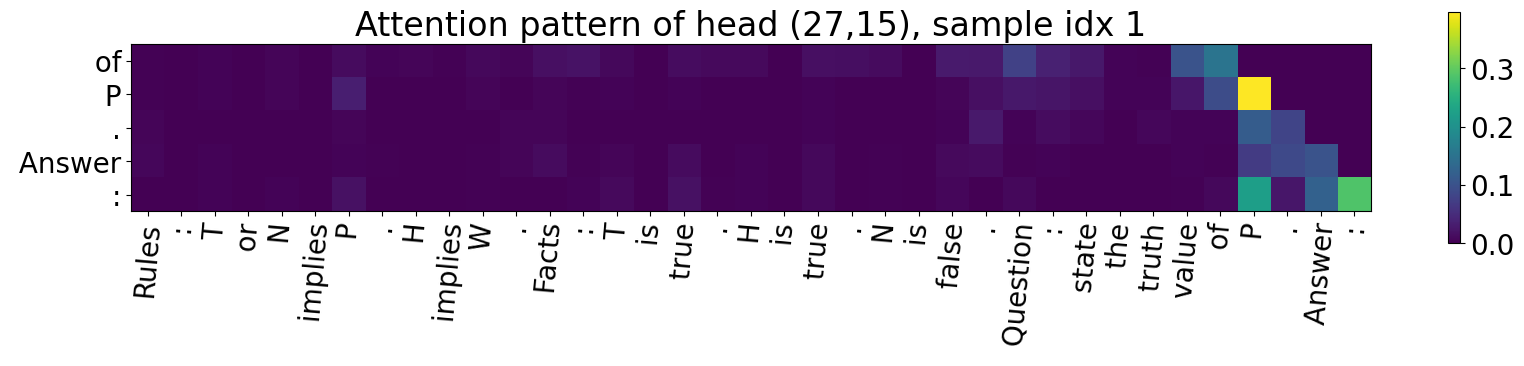

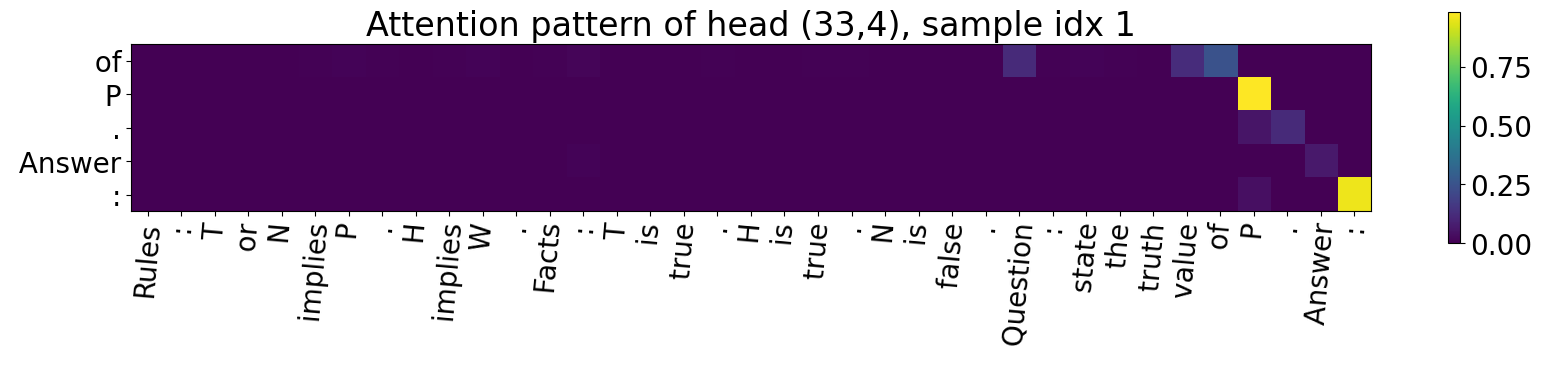

In [ ]:
visualize_heads(heads_vis = [(27,15), (33,4)], sample_idx=1)

### Attention statistics

Having seen the distinct attention patterns of these heads, let us now calculate the statistics of these attention heads, at the positions of interest (e.g. how much attention the rule locators put on the queried rule on average).



In [ ]:
from helpers.attn_analysis_helpers import clause_token_spans_for_batch
from helpers.attn_analysis_helpers import head_attention_mass_at_pos

#### Compute attention statistics

In [ ]:
batch_size=4
n_batch=2  # sanity check; increase this for statistical significance!

# We compute attention mass relative to the total attention mass on the final problem
# (exclude the in-context examples).
# You can also set this to False to see the absolute attention mass for the heads.
normalize_by_relevant_mass=True

In [ ]:
# Code is somewhat repetitive!
# Queried-rule locators.
queried_rule_locators = [(19,11), (21,0), (21,7), (22, 5), (23, 12)]
attention_mass_history = {}
max_other_mass_history = {}
for head in queried_rule_locators:
    ll, hh = head
    attention_mass_history[(ll,hh)] = []
    max_other_mass_history[(ll,hh)] = []

for head in queried_rule_locators:
    ll, hh = head
    for batch_idx in range(n_batch):
        spans_list = clause_token_spans_for_batch(clean_tokens[batch_size*batch_idx : batch_size*(batch_idx + 1)],
                                                  model,
                                                  clean_prob_info[batch_size*batch_idx : batch_size*(batch_idx + 1)])
        spans_by_label = {'queried_rule': [spans_list[b]['queried_rule'] for b in range(len(spans_list))]}
        stats = head_attention_mass_at_pos(
            model,
            clean_tokens[batch_size*batch_idx: batch_size*(batch_idx + 1)],
            clean_prob_info[batch_size*batch_idx: batch_size*(batch_idx + 1)],
            layer_idx=ll,
            head_idx=hh,
            dest_pos=-4,  # destination at the QUERY token position, -4.
            spans_by_label=spans_by_label,
            normalize=normalize_by_relevant_mass
        )
        attention_mass_history[(ll,hh)]+=stats['by_span']['queried_rule']['mass']
        max_other_mass_history[(ll,hh)]+=stats['max_other_in_problem']

print("The following numerical values are presented in the format of (Average, Standard deviation)")
for head in queried_rule_locators:
    ll,hh = head
    print("Head ("+str(ll)+","+str(hh)+") attention on queried rule, (avg, std): ", np.mean(attention_mass_history[(ll,hh)]), np.std(attention_mass_history[(ll,hh)]))
    print("Head ("+str(ll)+","+str(hh)+") max attention on other positions, (avg, std): ", np.mean(max_other_mass_history[(ll,hh)]), np.std(max_other_mass_history[(ll,hh)]))

The following numerical values are presented in the format of (Average, Standard deviation)
Head (19,11) attention on queried rule, (avg, std):  0.9770239866852055 0.02027086159627467
Head (19,11) max attention on other positions, (avg, std):  0.01855644407457656 0.017384135186778255
Head (21,0) attention on queried rule, (avg, std):  0.2634894129677641 0.0696187524085739
Head (21,0) max attention on other positions, (avg, std):  0.13748537961173557 0.03238880078052041
Head (21,7) attention on queried rule, (avg, std):  0.8587074872207814 0.10294013783698647
Head (21,7) max attention on other positions, (avg, std):  0.05067948936181177 0.06397744027273188
Head (22,5) attention on queried rule, (avg, std):  0.737448820552093 0.14769900586653384
Head (22,5) max attention on other positions, (avg, std):  0.1395987038261448 0.13096178970373606
Head (23,12) attention on queried rule, (avg, std):  0.8924938856678151 0.028252246149392188
Head (23,12) max attention on other positions, (avg, st

*Technical remark on attention statistics calculations*.

We implemented ```clause_token_spans_for_batch``` and ```head_attention_mass_at_pos``` very much independently of the exact logic problems studied in this work, to ensure a reasonable degree of comptability of these functions with more general logic problems (relatively easy to modify for other problems). ```clause_token_spans_for_batch``` essentially performs sub-sequence matching between a batch of input sentences and prompts, at the level of token IDs. In particular, ```clause_token_spans_for_batch``` uses problem information, which is a list of dictionaries each of the form `{'queried_rule': queried rule string, 'correct fact': correct fact string}`, to locate, at the token-ID level, what is the starting and ending token positions for the queried rule and correct fact in the batch of tokenized input prompts `clean_tokens` (this is performed sample-wise over the batch of inputs). ```clause_token_spans_for_batch``` then returns `spans_by_label`, a list of token position tuples of the queried rule and correct fact. The relevant token-ID spans are then used by ```head_attention_mass_at_pos``` to compute the attention statistics.

In [ ]:
# Queried-rule movers
queried_rule_movers = [(23,6), (20,7), (24,15)]
attention_mass_history = {}
max_other_mass_history = {}
for head in queried_rule_movers:
    ll, hh = head
    attention_mass_history[(ll,hh)] = []
    max_other_mass_history[(ll,hh)] = []

for head in queried_rule_movers:
    ll, hh = head
    for batch_idx in range(n_batch):
        spans_list = clause_token_spans_for_batch(clean_tokens[batch_size*batch_idx : batch_size*(batch_idx + 1)],
                                                  model,
                                                  clean_prob_info[batch_size*batch_idx : batch_size*(batch_idx + 1)])
        # As noted in Appendix B.8.2 in the paper, the mover heads in Gemma-2-9B have a more
        # diffuse behavior compared to Mistral-7B-v0.1, as they tend to place fixed attention on
        # not only QUERY, but also the tokens following it, which contain no
        # information for the logic question, but seem to act as intermediate positions
        # for moving the available information from QUERY toward the last token position.
        # If you are working with Mistral-7B here, try setting the span to (-4,-4). You should be able to
        # find that model's mover heads to have more focused (and fixed) attention on QUERY.
        spans_by_label = {'QUERY_after': [(-4, -2) for b in range(len(spans_list))]
                          }
        stats = head_attention_mass_at_pos(
            model,
            clean_tokens[batch_size*batch_idx: batch_size*(batch_idx + 1)],
            clean_prob_info[batch_size*batch_idx: batch_size*(batch_idx + 1)],
            layer_idx=ll,
            head_idx=hh,
            dest_pos=-1,  # destination at the last token position
            spans_by_label=spans_by_label,
            normalize=normalize_by_relevant_mass
        )
        attention_mass_history[(ll,hh)].append(stats['by_span']['QUERY_after']['mass'])
        max_other_mass_history[(ll,hh)].append(stats['max_other_in_problem'])

print("The following numerical values are presented in the format of (Average, Standard deviation)")
for head in queried_rule_movers:
    ll,hh = head
    print("Head ("+str(ll)+","+str(hh)+") attention on QUERY and after: ", np.mean(attention_mass_history[(ll,hh)]), np.std(attention_mass_history[(ll,hh)]))
    print("Head ("+str(ll)+","+str(hh)+") max attention on other positions: ", np.mean(max_other_mass_history[(ll,hh)]), np.std(max_other_mass_history[(ll,hh)]))

The following numerical values are presented in the format of (Average, Standard deviation)
Head (23,6) attention on QUERY and after:  0.48575105663687784 0.06279009190291499
Head (23,6) max attention on other positions:  0.11152082062585028 0.021440033403012152
Head (20,7) attention on QUERY and after:  0.30014004955474255 0.07838410915218813
Head (20,7) max attention on other positions:  0.11431778692871264 0.04556776050428176
Head (24,15) attention on QUERY and after:  0.6926133544822001 0.07101056721241086
Head (24,15) max attention on other positions:  0.19993731691851258 0.06162545000931513


In [ ]:
# Fact processors
fact_processors = [(24,5), (25,7), (26,0), (26,12)]

attention_mass_fact_history = {}
attention_mass_QUERY_history = {}
max_other_mass_history = {}
for head in fact_processors:
    ll, hh = head
    attention_mass_fact_history[(ll,hh)] = []
    attention_mass_QUERY_history[(ll,hh)] = []
    max_other_mass_history[(ll,hh)] = []

for head in fact_processors:
    ll, hh = head
    for batch_idx in range(n_batch):
        spans_list = clause_token_spans_for_batch(clean_tokens[batch_size*batch_idx : batch_size*(batch_idx + 1)],
                                                  model,
                                                  clean_prob_info[batch_size*batch_idx : batch_size*(batch_idx + 1)])
        spans_by_label = {'correct_fact': [spans_list[b]['correct_fact'] for b in range(len(spans_list))],
                          "QUERY":  [(-4, -3) for b in range(len(spans_list))]}
        stats = head_attention_mass_at_pos(
            model,
            clean_tokens[batch_size*batch_idx: batch_size*(batch_idx + 1)],
            clean_prob_info[batch_size*batch_idx: batch_size*(batch_idx + 1)],
            layer_idx=ll,
            head_idx=hh,
            dest_pos=-1,  # destination at the last token position
            spans_by_label=spans_by_label,
            normalize=normalize_by_relevant_mass
        )
        attention_mass_fact_history[(ll,hh)]+=stats['by_span']['correct_fact']['mass']
        attention_mass_QUERY_history[(ll,hh)]+=stats['by_span']['QUERY']['mass']
        max_other_mass_history[(ll,hh)]+=stats['max_other_in_problem']

print("The following numerical values are presented in the format of (Average, Standard deviation)")
for head in fact_processors:
    ll,hh = head
    print("Head ("+str(ll)+","+str(hh)+") attention on correct fact: ", np.mean(attention_mass_fact_history[(ll,hh)]), np.std(attention_mass_fact_history[(ll,hh)]))
    print("Head ("+str(ll)+","+str(hh)+") attention on QUERY: ", np.mean(attention_mass_QUERY_history[(ll,hh)]), np.std(attention_mass_QUERY_history[(ll,hh)]))
    print("Head ("+str(ll)+","+str(hh)+") max attention on other positions: ", np.mean(max_other_mass_history[(ll,hh)]), np.std(max_other_mass_history[(ll,hh)]))

The following numerical values are presented in the format of (Average, Standard deviation)
Head (24,5) attention on correct fact:  0.4248875817246015 0.19980799077964412
Head (24,5) attention on QUERY:  0.23631649034218155 0.08439926944982917
Head (24,5) max attention on other positions:  0.11394285815693654 0.07600666998136665
Head (25,7) attention on correct fact:  0.3964688776984821 0.10112223488510053
Head (25,7) attention on QUERY:  0.14846944771027962 0.1085778242240642
Head (25,7) max attention on other positions:  0.12491989966974462 0.02892039270659816
Head (26,0) attention on correct fact:  0.4948667732569339 0.15562179996847605
Head (26,0) attention on QUERY:  0.017500077122227065 0.00954755454340019
Head (26,0) max attention on other positions:  0.09468325854582335 0.034406340560966246
Head (26,12) attention on correct fact:  0.6295715537558052 0.12676169001038573
Head (26,12) attention on QUERY:  0.0011709597873272152 0.0012725333989227232
Head (26,12) max attention on ot

In [ ]:
# Decision heads
decision = [(28, 12), (30, 9)]
attention_mass_history = {}
max_other_mass_history = {}
for head in decision:
    ll, hh = head
    attention_mass_history[(ll,hh)] = []
    max_other_mass_history[(ll,hh)] = []

for head in decision:
    ll, hh = head
    for batch_idx in range(n_batch):
        spans_list = clause_token_spans_for_batch(clean_tokens[batch_size*batch_idx : batch_size*(batch_idx + 1)],
                                                  model,
                                                  clean_prob_info[batch_size*batch_idx : batch_size*(batch_idx + 1)])
        spans_by_label = {"correct_token_rule": [(spans_list[b]['queried_rule'][0], spans_list[b]['queried_rule'][0]) for b in range(len(spans_list))],
                          "correct_token_fact": [(spans_list[b]['correct_fact'][0], spans_list[b]['correct_fact'][0]) for b in range(len(spans_list))],}
        stats = head_attention_mass_at_pos(
            model,
            clean_tokens[batch_size*batch_idx: batch_size*(batch_idx + 1)],
            clean_prob_info[batch_size*batch_idx: batch_size*(batch_idx + 1)],
            layer_idx=ll,
            head_idx=hh,
            dest_pos=-1,  # destination at the last token position
            spans_by_label=spans_by_label,
            normalize=normalize_by_relevant_mass
        )
        summed_mass = [stats['by_span']['correct_token_rule']['mass'][n]+stats['by_span']['correct_token_fact']['mass'][n] for n in range(batch_size)]
        attention_mass_history[(ll,hh)]+=summed_mass
        max_other_mass_history[(ll,hh)]+=stats['by_span']['correct_token_fact']['max_other_in_problem']

print("The following numerical values are presented in the format of (Average, Standard deviation)")
for head in decision:
    ll,hh = head
    print("Head ("+str(ll)+","+str(hh)+") attention on correct answer token: ", np.mean(attention_mass_history[(ll,hh)]), np.std(attention_mass_history[(ll,hh)]))
    print("Head ("+str(ll)+","+str(hh)+") max attention on other positions: ", np.mean(max_other_mass_history[(ll,hh)]), np.std(max_other_mass_history[(ll,hh)]))

The following numerical values are presented in the format of (Average, Standard deviation)
Head (28,12) attention on correct answer token:  0.4722356081016365 0.12119263999287175
Head (28,12) max attention on other positions:  0.13249613835234103 0.03125452170270915
Head (30,9) attention on correct answer token:  0.8232187002295704 0.10187370964327534
Head (30,9) max attention on other positions:  0.0725835983955649 0.04585039276113123


## Circuit verification

Having surfaced the attention heads with nontrivial causal scores and interpreted their attention patterns, let us now try to see if this set of attention heads can actually explain a good portion of the model's performance on our logic problems.

Let us take a closer look at the token positions we keep the information flow normal (and every other activation ablated with counterfactual activations).

1. Queried-rule locator heads: as we noted before in analyzing the attention patterns, these heads place significant attention on the queried rule when we set the destination token position to be QUERY. We allow them to operate normally at the QUERY position only.
2. Mover heads: these heads are observed to place consistent attention on QUERY up to the last token position. We allow them to operate normally at the QUERY and last token position.
3. Fact-processing and decision heads: we observed before that these heads primarily perform their function at the last token position (as the destination position), namely locating the correct fact-sentence and focusing attention on the correct answer token to write down, respectively. Therefore, we only set -1 as the token position on which they are allowed to operate normally.
4. Post-processing heads: these attention heads are allowed to be unfrozen/operate normally on the QUERY and last token position, since we saw that they tend to have heavy "diagonal" attention at these two token positions.

Note for Mistral-7B: this notebook focuses on Gemma-2-9B, but if you're working with Mistral, we found that model to possess more focused attention, so you can just set unfrozen token position for the mover heads to the last token position only. Performance recovery should already be >90% for that case.

Implementation note: this implementation of circuit verification follows that in the [Arena IOI circuit analysis](https://arena-chapter1-transformer-interp.streamlit.app/%5B1.4.1%5D_Indirect_Object_Identification) closely. The main difference is that we are not performing mean-ablation, but a more targeted ablation with model activations from counterfactual prompts. This helps us verify components which are core to the cognitive function of answering the logic questions in our setting, instead of forcing us to include low-level components (e.g. binding token information in a sentence to the last token or the "." token, induction heads, etc.). In other words, mean-ablations are simply not discriminative and "surgical" enough for our purposes.

In [ ]:
from helpers.verification import add_ctfl_ablation_hook

In [ ]:
def circuit_specification(circuit_option="full"):
    """
    circuit_options can be ["full", "ablate locators", "ablate movers",
    "ablate fact proc", "ablate decision"]
    """
    circuit = {
        "queried rule locator": [(17,9), (19,11), (21,0), (21,7), (22,5), (23,12)],
        "mover": [(20,7), (23,6), (24,15)],
        "facts processing": [(24,5), (25,7), (26,0), (26,12)],
        "decision": [(28,12), (30,9)],
        "post-process": [(27,15), (33,4)]
    }

    # -4 corresponds to the QUERY position; -1 corresponds to the last token position
    normal_token_positions = {}
    normal_token_positions["queried rule locator"] = [] if circuit_option=="ablate locators" else [-4]
    normal_token_positions["mover"] = [] if circuit_option=="ablate movers" else [-4, -1]
    normal_token_positions["facts processing"] = [] if circuit_option=="ablate fact proc" else [-1]
    normal_token_positions["decision"] = [] if circuit_option=="ablate decision" else [-1]
    normal_token_positions["post-process"] = [] if circuit_option=="ablate post-process" else [-4, -1]

    return circuit, normal_token_positions

In [ ]:
n_batch = 30
batch_size = 8
# 240 samples for testing this circuit. We can recover the
# unintervened performance just with ~3% of the attention heads.

circuit_logit_diff_history = []
clean_logit_diff_history = []

for batch_idx in tqdm(range(n_batch)):
    model.reset_hooks(including_permanent=True)
    circuit, normal_token_positions = circuit_specification(circuit_option="full")
    model = add_ctfl_ablation_hook(model, ctfl_dataset=corrupted_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], circuit=circuit, seq_pos_to_keep=normal_token_positions)

    circuit_logits = model(clean_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)])
    circuit_logit_diffs = logits_diff(circuit_logits, answer_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], per_prompt=True)
    circuit_logit_diff_history.append(circuit_logit_diffs)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# recovery for the 4-shot case
print("Average logit difference of circuit:", np.mean(circuit_logit_diff_history))
# Clean logit difference of Gemma-2-9B, averaged over 240 samples: 1.8642977
print("Percentage performance recovery:", 100*np.mean(circuit_logit_diff_history)/average_clean_logit_difference)

Average logit difference of circuit: 1.9937432
Percentage performance recovery: 106.94338840361988


Good, we recovered the un-intervened model's performance (measured via average logit difference). Now, how about removing one of the family of attention heads then? We wish to add further to the necessity evidence of each attention head family, and provide coarse-grained, family-level minimality evidence for our circuit.

Let us go through the attention-head families, ablating them each while keeping the rest of the circuit.

In [ ]:
circuit_logit_diff_history = []

n_batch = 15  # For faster experiments. Feel free to increase it.
for batch_idx in tqdm(range(n_batch)):
    model.reset_hooks(including_permanent=True)
    circuit, normal_token_positions = circuit_specification(circuit_option="ablate locators")
    model = add_ctfl_ablation_hook(model, ctfl_dataset=corrupted_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], circuit=circuit, seq_pos_to_keep=normal_token_positions)

    circuit_logits = model(clean_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)])
    circuit_logit_diffs = logits_diff(circuit_logits, answer_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], per_prompt=True)
    circuit_logit_diff_history += circuit_logit_diffs
print("Ablating queried-rule locators, percent performance recovery: ", 100*np.mean(circuit_logit_diff_history)/average_clean_logit_difference)

  0%|          | 0/15 [00:00<?, ?it/s]

Ablating queried-rule locators, percent performance recovery:  -89.7182486987705


In [ ]:
circuit_logit_diff_history = []

n_batch = 15  # For faster experiments. Feel free to increase it.
for batch_idx in tqdm(range(n_batch)):
    model.reset_hooks(including_permanent=True)
    circuit, normal_token_positions = circuit_specification(circuit_option="ablate movers")
    model = add_ctfl_ablation_hook(model, ctfl_dataset=corrupted_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], circuit=circuit, seq_pos_to_keep=normal_token_positions)

    circuit_logits = model(clean_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)])
    circuit_logit_diffs = logits_diff(circuit_logits, answer_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], per_prompt=True)
    circuit_logit_diff_history += circuit_logit_diffs
print("Ablating movers, percent performance recovery: ", 100*np.mean(circuit_logit_diff_history)/average_clean_logit_difference)

  0%|          | 0/15 [00:00<?, ?it/s]

Ablating movers, percent performance recovery:  -40.92907841190245


In [ ]:
circuit_logit_diff_history = []

n_batch = 15  # For faster experiments. Feel free to increase it.
for batch_idx in tqdm(range(n_batch)):
    model.reset_hooks(including_permanent=True)
    circuit, normal_token_positions = circuit_specification(circuit_option="ablate fact proc")
    model = add_ctfl_ablation_hook(model, ctfl_dataset=corrupted_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], circuit=circuit, seq_pos_to_keep=normal_token_positions)

    circuit_logits = model(clean_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)])
    circuit_logit_diffs = logits_diff(circuit_logits, answer_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], per_prompt=True)
    circuit_logit_diff_history += circuit_logit_diffs
print("Ablating fact processors, percent performance recovery: ", 100*np.mean(circuit_logit_diff_history)/average_clean_logit_difference)

  0%|          | 0/15 [00:00<?, ?it/s]

Ablating fact processors, percent performance recovery:  -45.356983432874884


In [ ]:
circuit_logit_diff_history = []

n_batch = 15  # For faster experiments. Feel free to increase it.
for batch_idx in tqdm(range(n_batch)):
    model.reset_hooks(including_permanent=True)
    circuit, normal_token_positions = circuit_specification(circuit_option="ablate decision")
    model = add_ctfl_ablation_hook(model, ctfl_dataset=corrupted_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], circuit=circuit, seq_pos_to_keep=normal_token_positions)

    circuit_logits = model(clean_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)])
    circuit_logit_diffs = logits_diff(circuit_logits, answer_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], per_prompt=True)
    circuit_logit_diff_history += circuit_logit_diffs
print("Ablating decision heads, percent performance recovery: ", 100*np.mean(circuit_logit_diff_history)/average_clean_logit_difference)

  0%|          | 0/15 [00:00<?, ?it/s]

Ablating decision heads, percent performance recovery:  -98.38416002493275


In [ ]:
circuit_logit_diff_history = []

n_batch = 15  # For faster experiments. Feel free to increase it.
for batch_idx in tqdm(range(n_batch)):
    model.reset_hooks(including_permanent=True)
    circuit, normal_token_positions = circuit_specification(circuit_option="ablate post-process")
    model = add_ctfl_ablation_hook(model, ctfl_dataset=corrupted_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], circuit=circuit, seq_pos_to_keep=normal_token_positions)

    circuit_logits = model(clean_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)])
    circuit_logit_diffs = logits_diff(circuit_logits, answer_tokens[batch_size*batch_idx: batch_size*(batch_idx+1)], per_prompt=True)
    circuit_logit_diff_history += circuit_logit_diffs
print("Ablating post-processing heads, percent performance recovery: ", 100*np.mean(circuit_logit_diff_history)/average_clean_logit_difference)

  0%|          | 0/15 [00:00<?, ?it/s]

Ablating post-processing heads, percent performance recovery:  87.1126820408875


In [ ]:
# Remove the permanent hooks, in case you still want to do something with the LLM
model.reset_hooks(including_permanent=True)

It is now clear that removing any one of the four core family of attention heads (from rule locating to decision) from the circuit renders the performance recovery basically trivial. This again demonstrates the necessity of the sub-circuits we surfaced in our circuit search process -- and according to our interpretations, they have different specialized roles in writing down the answer token.

The *post-processing* heads are worth an extra note. While they do contribute to recovering the performance (since ablating them causes a nontrivial performance drop), *the drop is much less significant compared to ablating the other four families of heads*, since we still recover ~90% of the performance with those four core families of heads alone. Therefore, the paper's main text focused on presenting those 4 critical families of attention heads, and delayed the discussion of these less important and more opaque post-processing heads to the appendix. It is currently unclear what is the exact function of these heads besides somehow boosting the "answer signals" from the core circuit (from the 4 families of heads). This is an interesting future direction to explore.